In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython import display

# Load processed data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv", index_col=0)

In [3]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,NaN,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,NaN,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,NaN,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


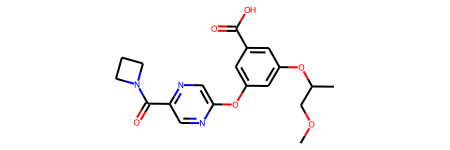

In [5]:
Chem.MolFromSmiles(dataset.iloc[3]["reactants"])

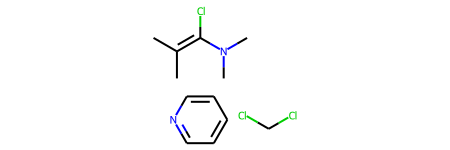

In [4]:
Chem.MolFromSmiles(dataset.iloc[3]["reagents"])

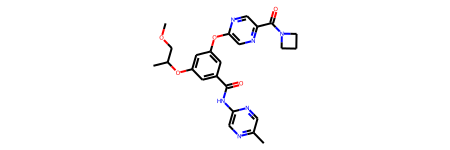

In [6]:
Chem.MolFromSmiles(dataset.iloc[3]["products"])

# Calculate property values

In [4]:
import tqdm
from rdkit.Chem import Crippen, QED, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

In [5]:
# some helper functions for the properties
def _mol(smile): 
    return Chem.MolFromSmiles(smile)
def _logp(smile): 
    return Crippen.MolLogP(_mol(smile))
def _qed(smile):
    mol = _mol(smile)
    return QED.qed(mol, QED.properties(mol))
def _sim(smile1, smile2):
    mol1 = _mol(smile1)
    mol2 = _mol(smile2)
    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [6]:
%%time
dataset["sim"] = dataset.apply(lambda row: _sim(row["reactants"], row["products"]), axis=1)

CPU times: user 7min 29s, sys: 89.9 ms, total: 7min 29s
Wall time: 7min 29s


In [7]:
%%time
dataset["reactant_logp"] = dataset.apply(lambda row: _logp(row["reactants"]), axis=1)
dataset["product_logp"] = dataset.apply(lambda row: _logp(row["products"]), axis=1)

CPU times: user 4min 9s, sys: 185 ms, total: 4min 9s
Wall time: 4min 9s


In [8]:
%%time
dataset["reactant_qed"] = dataset.apply(lambda row: _qed(row["reactants"]), axis=1)
dataset["product_qed"] = dataset.apply(lambda row: _qed(row["products"]), axis=1)

CPU times: user 24min 21s, sys: 213 ms, total: 24min 22s
Wall time: 24min 22s


In [9]:
%%time
dataset["logp%"] = dataset.apply(lambda row: (row["product_logp"]-row["reactant_logp"])/row["reactant_logp"]*100, axis=1)
dataset["qed%"] = dataset.apply(lambda row: (row["product_qed"]-row["reactant_qed"])/row["reactant_qed"]*100, axis=1)

CPU times: user 7.8 s, sys: 104 ms, total: 7.9 s
Wall time: 7.9 s


# Plots

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

sns.set(rc={'figure.figsize':(16, 6)})

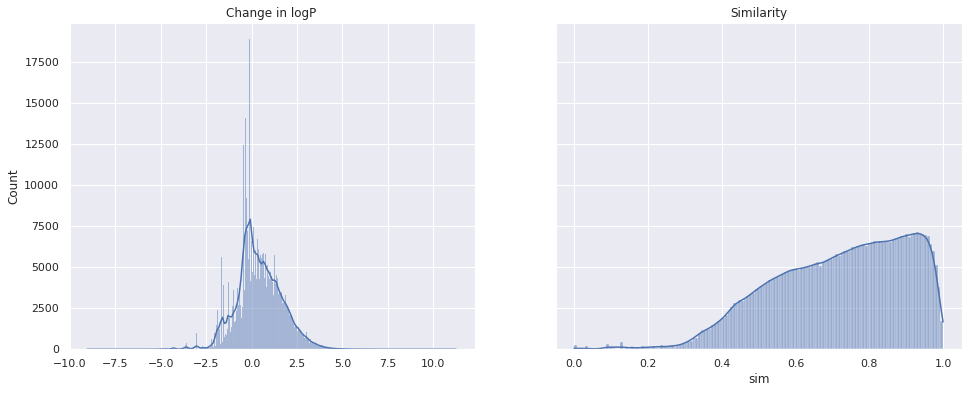

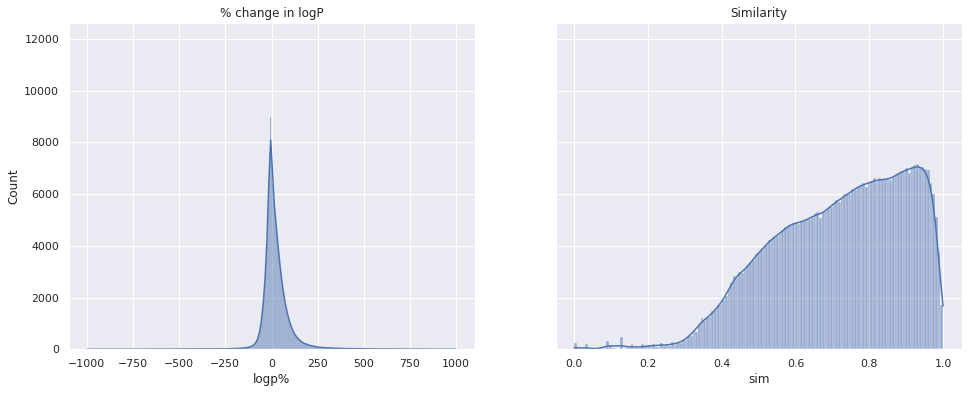

In [41]:
subfig, ax = plt.subplots(1, 2, sharey=True)

fig = sns.histplot(dataset["product_logp"]-dataset["reactant_logp"], kde=True, ax=ax[0])
fig.set(title=f"Change in logP")

fig = sns.histplot(dataset["sim"], kde=True, ax=ax[1])
fig.set(title=f"Similarity")
plt.show()

subfig, ax = plt.subplots(1, 2, sharey=True)

fig = sns.histplot((dataset[abs(dataset["logp%"])<1000]["logp%"]), kde=True, ax=ax[0])
fig.set(title=f"% change in logP")

fig = sns.histplot(dataset["sim"], kde=True, ax=ax[1])
fig.set(title=f"Similarity")
plt.show()

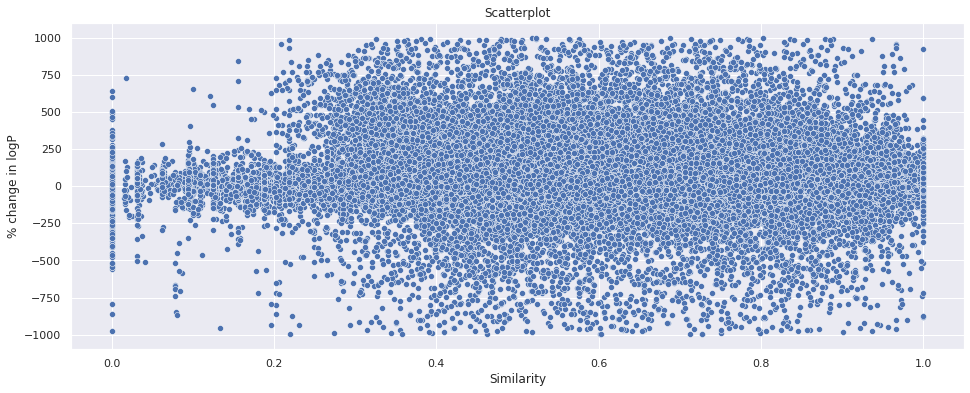

In [15]:
# Plotting against each other
sns.scatterplot(x=dataset["sim"], y=dataset[abs(dataset["logp%"])<1000]["logp%"])
plt.title("Scatterplot")
plt.xlabel("Similarity")
plt.ylabel("% change in logP")
plt.show()

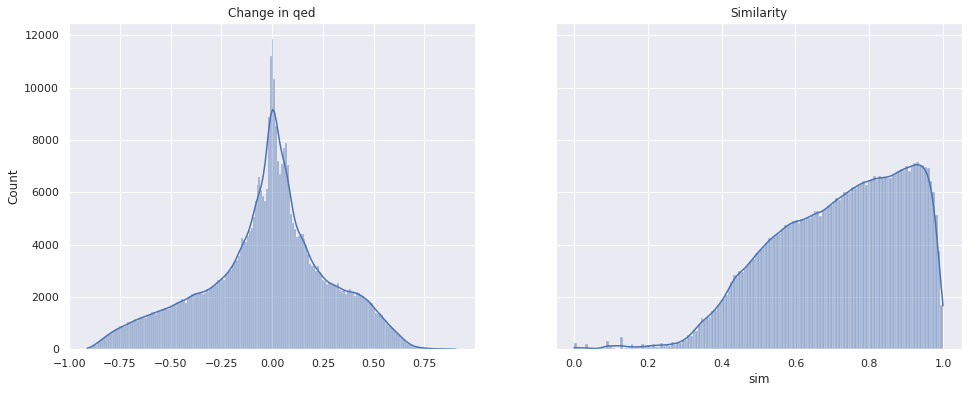

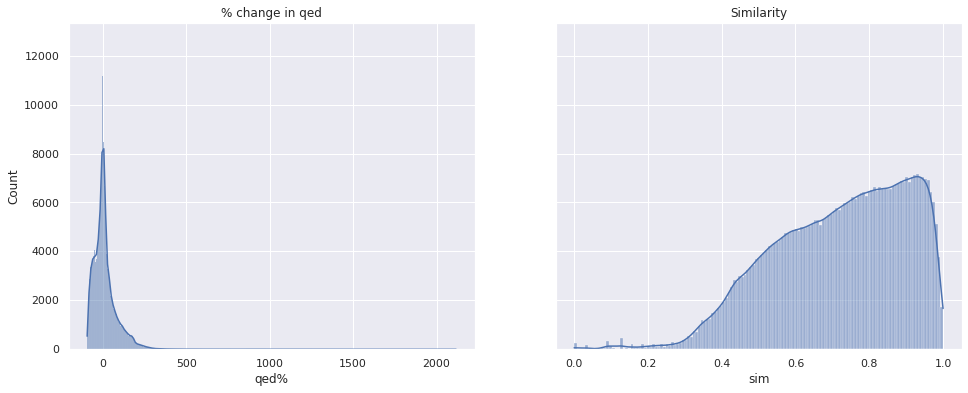

In [32]:
subfig, ax = plt.subplots(1, 2, sharey=True)

fig = sns.histplot(dataset["product_qed"]-dataset["reactant_qed"], kde=True, ax=ax[0])
fig.set(title=f"Change in qed")

fig = sns.histplot(dataset["sim"], kde=True, ax=ax[1])
fig.set(title=f"Similarity")
plt.show()

subfig, ax = plt.subplots(1, 2, sharey=True)

fig = sns.histplot(dataset["qed%"], kde=True, ax=ax[0])
fig.set(title=f"% change in qed")

fig = sns.histplot(dataset["sim"], kde=True, ax=ax[1])
fig.set(title=f"Similarity")
plt.show()

In [19]:
q = dataset["qed%"]
q.min(), q.max()

(-95.07111931267053, 2116.673181603173)

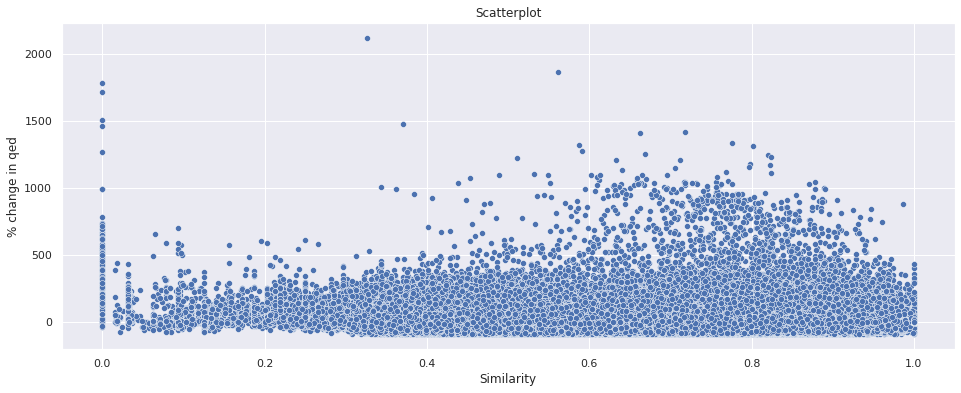

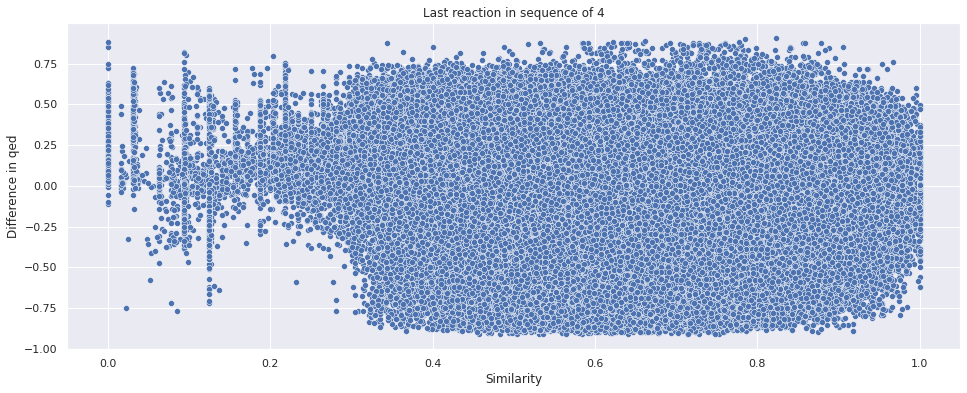

In [33]:
# Plotting against each other
sns.scatterplot(x=dataset["sim"], y=dataset["qed%"])
plt.title("Scatterplot")
plt.xlabel("Similarity")
plt.ylabel("% change in qed")
plt.show()

# Plotting against each other
sns.scatterplot(x=dataset["sim"], y=dataset["product_qed"]-dataset["reactant_qed"])
plt.title("Last reaction in sequence of 4")
plt.xlabel("Similarity")
plt.ylabel("Difference in qed")
plt.show()